<a href="https://colab.research.google.com/github/yuriarciniegas/yoaprendo1/blob/master/CineColombiano_Sklearn_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

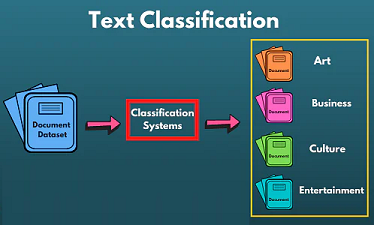

**Step 1: Read and Organize Data**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

#Read data from Google Sheet: experimentos.analitica.datos - EncuestaCineColombiano_Respuestas
df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQC3CXrmRk6mpK9-DrpO--faGVT_KsR8rj-AToUfFlsbKNnUB2wVslmNYiFT1pv80Z5gp76tgSqp1aN/pub?gid=1802142849&single=true&output=tsv", sep="\t")

df.columns = ['A','B','C','D','E']

#Transform dataset: Opinion-Type
good_df = df[['C']]
good_df['Opinion'] = "POSITIVE"

bad_df = df[['D']]
bad_df.columns = ['C']
bad_df['Opinion'] = "NEGATIVE"

df_op = pd.concat([good_df,bad_df])
df_op.columns = ['Opinion','Type']

print(df_op.head())

df_op.groupby(['Type']).count()

**Step 2: Define a text preprocessing function**

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from string import punctuation
import unicodedata

nltk.download('stopwords')
stemmer = SnowballStemmer('spanish')
nltk.download('punkt')

stop_words = set(stopwords.words('spanish'))
stop_words = stop_words.union(set(['pelicul', 'colombian', 'cin', 'me', 'le', 'da', 'mi', 'su', 'ha', 'he', 'ya', 'un', 'una', 'es','del', 'las', 'los', 'en', 'que', 'y', 'la','de']))

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

def fast_preproc(text):
  text = text.lower()
  text = ''.join(c for c in text if not c.isdigit())
  text = ''.join(c for c in text if c not in punctuation)
  text = remove_accents(text)
  words = word_tokenize(text)
  words = [stemmer.stem(word) for word in words]
  words = [word for word in words if not word in stop_words]
  try:
    text = " ".join(str(word) for word in words)
  except Exception as e:
    print(e)
    pass
  return text

print(fast_preproc("áéíóú ÁÉÍÓÚ FRAN Romero; Análisis de Textos."))

**Step 3: Text preprocessing**

In [ ]:
df_op['Opinion'] = df_op['Opinion'].astype(str)

df_op = df_op.assign(
    TextPreproc=lambda df: df_op.Opinion.apply(fast_preproc)
)

df_op.head()

**Step 4: Split dataset**

In [ ]:
#Split dataset
X = df_op['TextPreproc']
Y = df_op['Type']

print("X:")
print(X[0:5])
print("\nY:")
print(Y[0:5])

**Step 5: Data transformation with TF_IDF**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(max_df=0.5)

#Tokenize and build vocabulary
vec.fit(X)
print("\nVocabulary:\n")
print(vec.vocabulary_)

#Encode documents
trans_text_train = vec.transform(X)

#Print Document-Term Matrix
df = pd.DataFrame(trans_text_train.toarray(), columns=vec.get_feature_names_out())
df.head()

#df.shape

**Step 6: Split Test-Train Datasets**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df, Y, test_size=0.1)
print("Train and test shapes:\n")
print("Train. X: " + str(X_train.shape) + " - Y:" + str(Y_train.shape))
print("Test. X: " + str(X_test.shape) + " - Y:" + str(Y_test.shape))

**Step 7. Build a Classifier**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

#Classic machine-learning algorithms
#classifier = LogisticRegression(random_state=0,penalty='l2',solver='lbfgs')
#classifier = DecisionTreeClassifier(random_state=0)
#classifier = RandomForestClassifier(random_state=0)

#Machine learning algorithms used in Text Classification
#classifier = svm.SVC()
classifier = MultinomialNB()

classifier.fit(X_train, Y_train)

from sklearn.metrics import classification_report,confusion_matrix

#Predice para el conjunto de testeo.
y_pred = classifier.predict(X_test)

print("\nMatriz de confusión:\n")
print(confusion_matrix(Y_test,y_pred))

print("\nEstadisticas del clasificador:\n")
print(classification_report(Y_test,y_pred))

**Step 8. Predict New Instance**

In [ ]:
new_opinion = ["Me parecen malas por la razon de que no llevan un hilo conductor claro"]
#new_opinion = ["Me gustan porque son chistosas"]

Xt_new = [fast_preproc(str(new_opinion))]

trans_new_doc = vec.transform(Xt_new) #Use same TfIdfVectorizer

print("\nPredicted result: " + str(classifier.predict(trans_new_doc)))


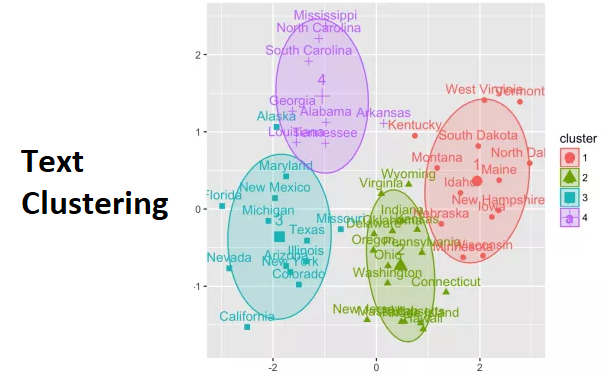

https://user.ceng.metu.edu.tr/~akifakkus/courses/ceng574/k-means/

**Step 8A: How many clusters?: Elbow method**

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

total = df_op.shape[0]
#opinions = trans_text_train[0:int(total/2)] #Positive opinions.
opinions = trans_text_train[int(total/2):] #Negative opinions.
print("POSITIVE OPINION SHAPE:")
print(opinions.shape)

square_distances = []
K = range(2,10)

for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10)
   km = km.fit(opinions)
   square_distances.append(km.inertia_)

plt.plot(K, square_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

**Step 8B: K-Means Clustering.**

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

final_K = 5

k_means_model = KMeans(n_clusters=final_K, init='k-means++', max_iter=200, n_init=10)
k_means_model.fit(opinions)

# Use PCA in order to reduce the features to 2D
pca = PCA(n_components=2, random_state=0)
reduced_features = pca.fit_transform(opinions.toarray())

# Reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(k_means_model.cluster_centers_)

#Create a scatter plot
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=k_means_model.predict(opinions))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

**Step 8C: Assign each opinion its respective cluster.**

In [ ]:
#opinions_df =  pd.DataFrame(df_op['TextPreproc'][0:int(total/2)])
opinions_df =  pd.DataFrame(df_op['TextPreproc'][int(total/2):])

df_l = pd.DataFrame(k_means_model.labels_)
opinions_df = pd.concat([opinions_df.reset_index(drop=True), df_l], axis=1)

opinions_df.columns = ['Text', 'Cluster']

opinions_df.head()

**Step 8D: Word cloud by each cluster**

In [ ]:
from wordcloud import WordCloud

for k in range(0,final_K):
   s=opinions_df[opinions_df.Cluster==k]
   text=s['Text'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])

   #Words
   #wordcloud = WordCloud(stopwords=stop_words, max_font_size=50, max_words=100, background_color="white").generate(text)

   #Bigrams
   wordcloud = WordCloud(collocation_threshold = 2, collocations= True, stopwords=stop_words, max_font_size=50, max_words=100, background_color="white").generate(text)

   print('Cluster: {}'.format(k))
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()